# M3 - Time Series Decomposition

## Melissa Bell

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [146]:
df_const = pd.read_csv('C:/Users/mbell/OneDrive/Desktop/Competing thru Business Analytics/CTBA/CTBA/M3/ConstructionTimeSeriesDataV2.csv')
#reading file

In [89]:
df_const.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


## Private Construction

### Looking at the *Private* Construction Data

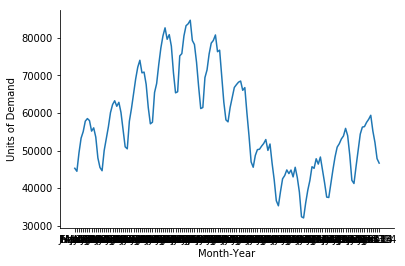

In [90]:
fig,ax = plt.subplots()
ax.plot(df_const['Month-Year'], df_const['Private Construction'], label='Private Construction')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### D(q)=L+T(q)+S(q)+ϵ(q)

In [91]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df_const.index,df_const['Private Construction'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 66985.60357841766     slope = -132.5985944684912      p_value =  3.965217656244861e-08


### The next cell of code computes the moving average of each point for a data window centered on each point. The window size is a variable that can be easily changed, and the average squared error is computed in order to help evaluate which window size is appropriate for the moving average.  I played with this until I got the smallest average squared error -- this was 28 windows.  

Average Squared Error per Month:  27906328.62513241
            Month Month-Year  Total Construction  Private Construction  \
2003-03-31     15     Mar-03               64506                 49996   
2003-04-30     16     Apr-03               69638                 53195   
2003-05-31     17     May-03               74473                 56286   
2003-06-30     18     Jun-03               80377                 60076   
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   
2003-12-31     24     Dec-03               71050                 55584   
2004-01-31     25     Jan-04               64934                 50975   
2004-02-29     26     Feb-04               64138            

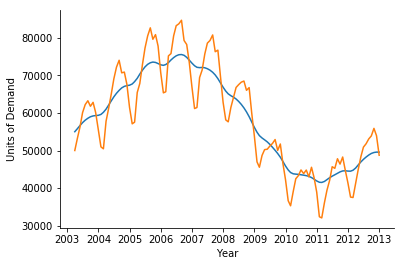

In [92]:
def sqErr(row):
    return (row['Private Construction'] - row['MovAvg'])**2
    
df_const['MovAvg'] = np.NaN
df_const['sqErr'] = np.NaN
# Changing the DataFrame index to DatetimeIndex data type is required for using one of the functions below
df_const.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df_const['Private Construction']))
#print(len(data),'\n',data)

window = 28
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is eing computed
for i in range(int(window/2),df_const.shape[0]-int(window/2)):
    df_const.loc[df_const.index[i],'MovAvg'] = (0.5*df_const.iloc[i - int(window/2)]['Private Construction'] + df_const.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*df_const.iloc[i + int(window/2)]['Private Construction'])/float(window)

df_const['sqErr'] = (df_const['Private Construction'] - df_const['MovAvg'])**2
# The squared error can eb computed also with the dfHA.apply() method below
# Using df_const.apply() in this case is unecessary complexity, but it is a good function to know about
#df_const['sqErr'] = df_const.apply(sqErr,axis='columns')

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
df_const.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(df_const['MovAvg'],label='Moving Average')
ax.plot(df_const['Private Construction'],label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(df_const['sqErr'])/len(df_const))
print(df_const)

### The residual Private Construction yet to be explained, $R1Private$, is computed by subtracting the moving average from the demand time series.  Also, these are included in this code cell:
- Computing $R1Private$ as a percentage of demand ($R1PrivateError$).
- The df_const.style.format command demonstrates how to display pandas DataFrame data in whicever readble format you prefer.

In [93]:
df_const['R1Private'] = df_const['Private Construction'] - df_const['MovAvg']
df_const['R1PrivateError'] = abs((df_const['Private Construction'] - df_const['R1Private'])/df_const['Private Construction'])
df_const.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1Private': '{:,.1f}'.format,
    'R1PrivateError': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,R1Private,R1PrivateError
2003-03-31 00:00:00,15,Mar-03,64506,49996,14510,55003.1,"25,071,479.6","-5,007.1",1.100
2003-04-30 00:00:00,16,Apr-03,69638,53195,16444,55794.5,"6,757,585.9","-2,599.5",1.049
2003-05-31 00:00:00,17,May-03,74473,56286,18187,56639.9,"125,214.9",-353.9,1.006
2003-06-30 00:00:00,18,Jun-03,80377,60076,20301,57416.5,"7,072,940.2","2,659.5",0.956
2003-07-31 00:00:00,19,Jul-03,82971,62216,20755,58066.0,"17,222,648.2","4,150.0",0.933
2003-08-31 00:00:00,20,Aug-03,85191,63234,21957,58578.6,"21,672,516.4","4,655.4",0.926
2003-09-30 00:00:00,21,Sep-03,83841,61767,22075,58974.1,"7,800,350.3","2,792.9",0.955
2003-10-31 00:00:00,22,Oct-03,83133,62813,20321,59198.7,"13,063,448.5","3,614.3",0.942
2003-11-30 00:00:00,23,Nov-03,77915,60115,17801,59295.5,"671,609.5",819.5,0.986
2003-12-31 00:00:00,24,Dec-03,71050,55584,15466,59357.0,"14,235,529.0","-3,773.0",1.068


### The cell below helps us visualize the remaining pattern to be decomposed, $R1Private$, and it also computes the average residual demand pattern.

Average Residual:  165.43719733656152


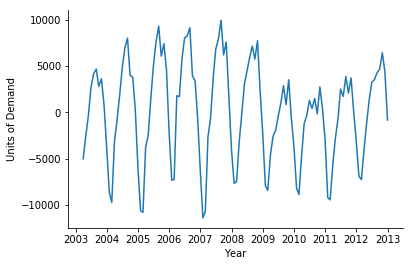

In [94]:
fig,ax = plt.subplots()
ax.plot(df_const['R1Private'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_const['R1Private'])/len(df_const))

### Just as seasonal demand had a higher autocorrelation when the data were offet by four periods, we need to use autocorrelation analysis to detect whether any cyclical patterns exist and how many periods before they are repeated.

In [95]:
maxCorr = 0.0
period = np.NaN
for i in range(1,29):
    corr = df_const['R1Private'].autocorr(lag=i)
    print('PrivateCorrelation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

PrivateCorrelation, lag  1     0.802817791693665
PrivateCorrelation, lag  2     0.4443534589868593
PrivateCorrelation, lag  3     0.020476842888635695
PrivateCorrelation, lag  4     -0.3395526458258491
PrivateCorrelation, lag  5     -0.5946355941654637
PrivateCorrelation, lag  6     -0.7256392985138465
PrivateCorrelation, lag  7     -0.626869741908392
PrivateCorrelation, lag  8     -0.396315840672076
PrivateCorrelation, lag  9     -0.0552300506808024
PrivateCorrelation, lag  10     0.350135855726644
PrivateCorrelation, lag  11     0.6979125314418182
PrivateCorrelation, lag  12     0.8927182172333037
PrivateCorrelation, lag  13     0.7167085973043467
PrivateCorrelation, lag  14     0.38251474913428596
PrivateCorrelation, lag  15     -0.01931861069919423
PrivateCorrelation, lag  16     -0.36054942226148884
PrivateCorrelation, lag  17     -0.598581299411287
PrivateCorrelation, lag  18     -0.7205781836890767
PrivateCorrelation, lag  19     -0.6202726789012772
PrivateCorrelation, lag  20  

### The code cell below:
- Breaks the time series into three components corresonding with each of the 9 cycles in the data.  Note that the 9th cycle is partial.
- Computes an average for each of the 12 points within the cycle over all intances of each point in the data
- Plots the average versus the 9 cycle instances within the data

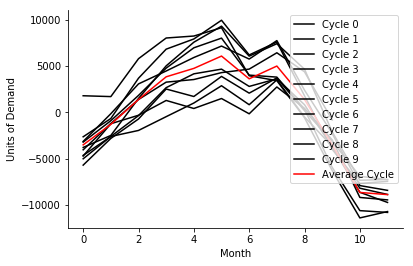

In [96]:
period = 12
cycleLen = period
numCycles = int(len(df_const)/cycleLen + 0.5)
cycles = [df_const.iloc[range(i*period,min((i+1)*period,len(df_const)))]['R1Private'] for i in range(numCycles)]
ptsInCycles = [df_const.iloc[range(i,len(df_const['R1Private']),period)]['R1Private'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

### This code cell:
- Inserts the appropriate $C\left( m \right)$ value into the $C$ column in the DataFrame for each Month $m$.
- Plots the cyclicality component $C\left( m \right)$ is plotted with the $R1Private$ column to see how well the cyclicality component and it match.

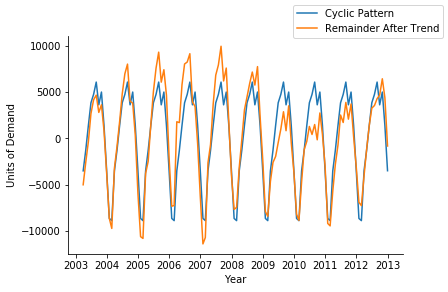

In [100]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(df_const)/cycleLen + 0.5)
df_const['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df_const)):
    df_const.loc[df_const.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(df_const['C'],label='Cyclic Pattern')
ax.plot(df_const['R1Private'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

### The code cell below does these:

- Computes the remaining residual home sales to be explained, $R2Private$, after subtracting the cyclical component, $C \left( m \right)$: this is the $\epsilon \left( m \right)$ in our model.
- Computes the error, $R2Private$, as a percentage of the demand time series.
- Computes the mathematical model 'fit', composed of the trend and cyclical components: $T\left( m \right) + C\left( m \right)$.
- Plots the fit of the model $T\left( m \right) + C\left( m \right)$ with the original data, $H \left( m \right)$.
- Computes the average absolute error of $R2PrivateError$ of the original demand time series.
- Removes the sqErr column because it is no longer needed

Average Error:  0.029087345816844315
            Month Month-Year  Total Construction  Private Construction  \
2003-03-31     15     Mar-03               64506                 49996   
2003-04-30     16     Apr-03               69638                 53195   
2003-05-31     17     May-03               74473                 56286   
2003-06-30     18     Jun-03               80377                 60076   
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   
2003-12-31     24     Dec-03               71050                 55584   
2004-01-31     25     Jan-04               64934                 50975   
2004-02-29     26     Feb-04               64138                 50449   
2

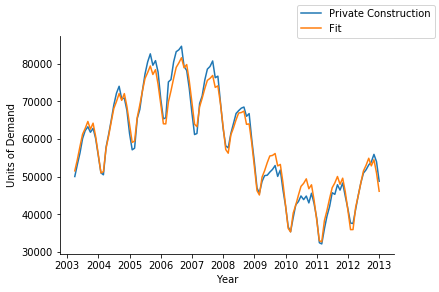

In [103]:
df_const['R2Private'] = df_const['R1Private'] - df_const['C']
df_const['R2PrivateError'] = abs(df_const['R2Private']/df_const['Private Construction'])
df_const['fit'] = df_const['MovAvg'] + df_const['C']
#df_const.drop(['sqErr'], axis = 1, inplace=True)
print('Average Error: ', sum(df_const['R2PrivateError'])/len(df_const))
print(df_const)
fig,ax = plt.subplots()
ax.plot(df_const['Private Construction'], label='Private Construction')
ax.plot(df_const['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

### Here is a plot of the residual $R2Private$ for visualization purposes to observe any remaining patterns that we might want to capture, and also an autocorrelation analysis of the residual.

Correlation, lag  1     0.8446702255487188
Correlation, lag  2     0.6856772914324839
Correlation, lag  3     0.47670453196300233
Correlation, lag  4     0.2961825065974407
Correlation, lag  5     0.12201147674153613
Correlation, lag  6     0.018030640845751147
Correlation, lag  7     -0.01103181311702084
Correlation, lag  8     0.03214110255292664
Correlation, lag  9     0.08090049607148378
Correlation, lag  10     0.16759151249935336
Correlation, lag  11     0.235860800944685
Correlation, lag  12     0.312781523770604
Correlation, lag  13     0.2643045810218506
Correlation, lag  14     0.2405132134140004
Correlation, lag  15     0.14663006598095085
Correlation, lag  16     0.07957478089488083
Correlation, lag  17     0.013725249111297253
Correlation, lag  18     -0.0022973062503892417
Correlation, lag  19     0.01146746274771384
Correlation, lag  20     0.04080124469406382
Correlation, lag  21     0.06344280618268007
Correlation, lag  22     0.09645627768063147
Correlation, lag  23  

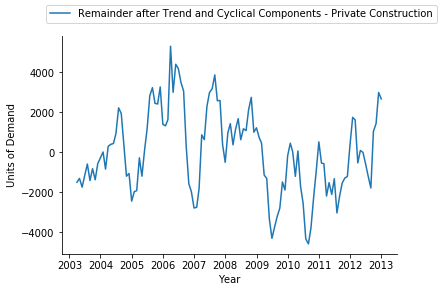

In [104]:
fig,ax = plt.subplots()
ax.plot(df_const['R2Private'],label='Remainder after Trend and Cyclical Components - Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,29):
    corr = df_const['R2Private'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

### A final graph to show the model versus the original data and, as well, the remander $R2Private$ to judge it relative to the original demand we were trying to fit.

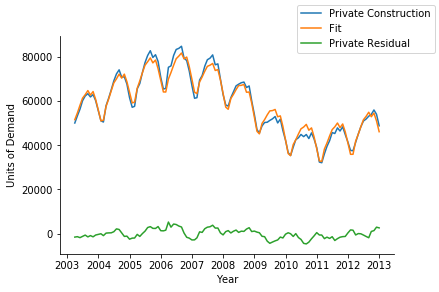

In [105]:
fig,ax = plt.subplots()
ax.plot(df_const['Private Construction'],label='Private Construction')
ax.plot(df_const['fit'],label='Fit')
ax.plot(df_const['R2Private'],label='Private Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

## Public Construction

### Looking at the *Public* Construction Data

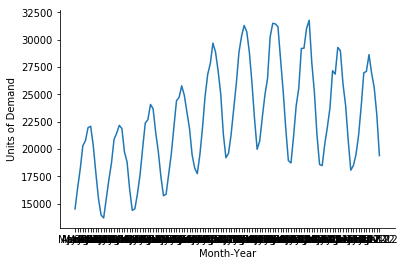

In [106]:
fig,ax = plt.subplots()
ax.plot(df_const['Month-Year'], df_const['Public Construction'], label='Public Construction')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### D(q)=L+T(q)+S(q)+ϵ(q)

In [109]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df_const.index,df_const['Public Construction'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 18327.939893765724     slope = 52.00857586303297      p_value =  3.028349007007645e-09


### The next cell of code computes the moving average of each point for a data window centered on each point. The window size is a variable that can be easily changed, and the average squared error is computed in order to help evaluate which window size is appropriate for the moving average.  I played with this until I got the smallest average squared error -- this was 3 windows.

Average Squared Error per Month:  144069.99869791666
            Month Month-Year  Total Construction  Private Construction  \
2002-02-28      2     Feb-02               58588                 44475   
2002-03-31      3     Mar-02               63782                 49396   
2002-04-30      4     Apr-02               69504                 53283   
2002-05-31      5     May-02               73384                 55009   
2002-06-30      6     Jun-02               77182                 57801   
2002-07-31      7     Jul-02               78863                 58494   
2002-08-31      8     Aug-02               79460                 57953   
2002-09-30      9     Sep-02               76542                 55157   
2002-10-31     10     Oct-02               75710                 56023   
2002-11-30     11     Nov-02               71362                 53552   
2002-12-31     12     Dec-02               63984                 48023   
2003-01-31     13     Jan-03               59877           

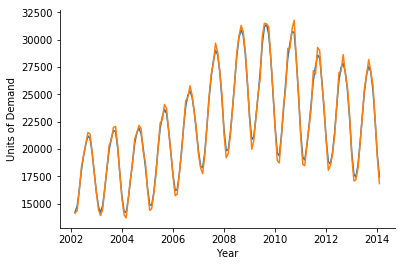

In [147]:
def sqErr(row):
    return (row['Public Construction'] - row['MovAvg'])**2
    
df_const['MovAvg'] = np.NaN
df_const['sqErr'] = np.NaN
# Changing the DataFrame index to DatetimeIndex data type is required for using one of the functions below
df_const.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df_const['Public Construction']))
#print(len(data),'\n',data)

window = 3
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is being computed
for i in range(int(window/2),df_const.shape[0]-int(window/2)):
    df_const.loc[df_const.index[i],'MovAvg'] = (0.5*df_const.iloc[i - int(window/2)]['Public Construction'] + df_const.iloc[i - int(window/2)+1:i + int(window/2)]['Public Construction'].sum() + 0.5*df_const.iloc[i + int(window/2)]['Public Construction'])/float(window)

df_const['sqErr'] = (df_const['Public Construction'] - df_const['MovAvg'])**2
# The squared error can eb computed also with the dfHA.apply() method below
# Using df_const.apply() in this case is unecessary complexity, but it is a good function to know about
#df_const['sqErr'] = df_const.apply(sqErr,axis='columns')

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
df_const.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(df_const['MovAvg'],label='Moving Average')
ax.plot(df_const['Public Construction'],label='Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(df_const['sqErr'])/len(df_const))
print(df_const)

### The residual Public Construction yet to be explained, $R1Public$, is computed by subtracting the moving average from the demand time series.  Also, these are included in this code cell:
- Computing $R1Public$ as a percentage of demand ($R1PublicError$).
- The df_const.style.format command demonstrates how to display pandas DataFrame data in whicever readble format you prefer.

In [148]:
df_const['R1Public'] = df_const['Public Construction'] - df_const['MovAvg']
df_const['R1PublicError'] = abs((df_const['Public Construction'] - df_const['R1Public'])/df_const['Public Construction'])
df_const.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1Public': '{:,.1f}'.format,
    'R1PublicError': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,R1Public,R1PublicError
2002-02-28 00:00:00,2,Feb-02,58588,44475,14113,14213.8,"10,150.6",-100.8,1.007
2002-03-31 00:00:00,3,Mar-02,63782,49396,14386,14776.5,"152,490.2",-390.5,1.027
2002-04-30 00:00:00,4,Apr-02,69504,53283,16221,16300.8,"6,360.1",-79.8,1.005
2002-05-31 00:00:00,5,May-02,73384,55009,18375,18088.0,"82,369.0",287.0,0.984
2002-06-30 00:00:00,6,Jun-02,77182,57801,19381,19376.5,20.2,4.5,1.000
2002-07-31 00:00:00,7,Jul-02,78863,58494,20369,20406.5,"1,406.2",-37.5,1.002
2002-08-31 00:00:00,8,Aug-02,79460,57953,21507,21192.0,"99,225.0",315.0,0.985
2002-09-30 00:00:00,9,Sep-02,76542,55157,21385,20991.0,"155,236.0",394.0,0.982
2002-10-31 00:00:00,10,Oct-02,75710,56023,19687,19642.2,"2,002.6",44.8,0.998
2002-11-30 00:00:00,11,Nov-02,71362,53552,17810,17817.0,49.0,-7.0,1.000


### The cell below helps us visualize the remaining pattern to be decomposed, $R1Public$, and it also computes the average residual demand pattern.

Average Residual:  -0.029513888888888888


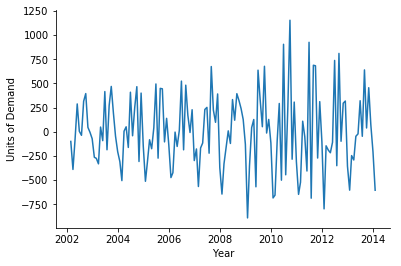

In [149]:
fig,ax = plt.subplots()
ax.plot(df_const['R1Public'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_const['R1Public'])/len(df_const))

### Just as seasonal demand had a higher autocorrelation when the data were offet by four periods, we need to use autocorrelation analysis to detect whether any cyclical patterns exist and how many periods before they are repeated.

In [155]:
maxCorr = 0.0
period = np.NaN
for i in range(1,29):
    corr = df_const['R1Public'].autocorr(lag=i)
    print('Public Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Public Correlation, lag  1     0.011583094881175943
Public Correlation, lag  2     0.15154821239200095
Public Correlation, lag  3     0.13019370901819396
Public Correlation, lag  4     -0.3698612222802355
Public Correlation, lag  5     -0.29274161489088024
Public Correlation, lag  6     -0.2525235805980383
Public Correlation, lag  7     -0.3549445859596358
Public Correlation, lag  8     -0.3378906013078828
Public Correlation, lag  9     0.1690612501697429
Public Correlation, lag  10     0.06388570698873079
Public Correlation, lag  11     0.19369072382394797
Public Correlation, lag  12     0.8110668146791021
Public Correlation, lag  13     -0.007893246629528762
Public Correlation, lag  14     0.29685840505323874
Public Correlation, lag  15     0.022507471676763088
Public Correlation, lag  16     -0.3517952314400056
Public Correlation, lag  17     -0.23214286484036534
Public Correlation, lag  18     -0.29591592901191627
Public Correlation, lag  19     -0.36012305706705844
Public Correlat

### The code cell below:
- Breaks the time series into three components corresonding with each of the 11 cycles in the data.  Note that the 11th cycle is partial.
- Computes an average for each of the 12 points within the cycle over all intances of each point in the data
- Plots the average versus the 11 cycle instances within the data

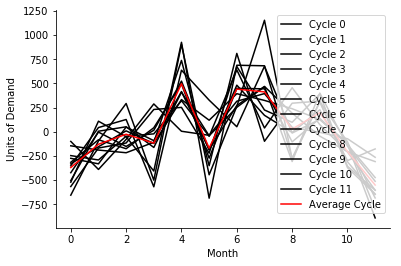

In [156]:
period = 12
cycleLen = period
numCycles = int(len(df_const)/cycleLen + 0.5)
cycles = [df_const.iloc[range(i*period,min((i+1)*period,len(df_const)))]['R1Public'] for i in range(numCycles)]
ptsInCycles = [df_const.iloc[range(i,len(df_const['R1Public']),period)]['R1Public'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

### This code cell:
- Inserts the appropriate $C\left( m \right)$ value into the $C$ column in the DataFrame for each Month $m$.
- Plots the cyclicality component $C\left( m \right)$ is plotted with the $R1Public$ column to see how well the cyclicality component and it match.

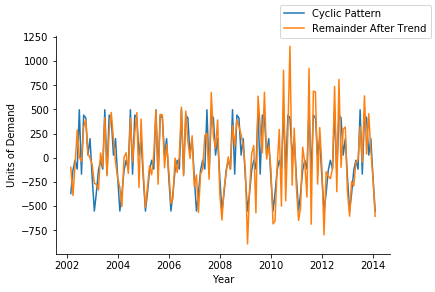

In [157]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(df_const)/cycleLen + 0.5)
df_const['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df_const)):
    df_const.loc[df_const.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(df_const['C'],label='Cyclic Pattern')
ax.plot(df_const['R1Public'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

### The code cell below does these:

- Computes the remaining residual home sales to be explained, $R2Public$, after subtracting the cyclical component, $C \left( m \right)$: this is the $\epsilon \left( m \right)$ in our model.
- Computes the error, $R2Public$, as a percentage of the demand time series.
- Computes the mathematical model 'fit', composed of the trend and cyclical components: $T\left( m \right) + C\left( m \right)$.
- Plots the fit of the model $T\left( m \right) + C\left( m \right)$ with the original data, $H \left( m \right)$.
- Computes the average absolute error of $R2PublicError$ of the original demand time series.
- Removes the sqErr column because it is no longer needed

Average Error:  0.007353616275439389
            Month Month-Year  Total Construction  Private Construction  \
2002-02-28      2     Feb-02               58588                 44475   
2002-03-31      3     Mar-02               63782                 49396   
2002-04-30      4     Apr-02               69504                 53283   
2002-05-31      5     May-02               73384                 55009   
2002-06-30      6     Jun-02               77182                 57801   
2002-07-31      7     Jul-02               78863                 58494   
2002-08-31      8     Aug-02               79460                 57953   
2002-09-30      9     Sep-02               76542                 55157   
2002-10-31     10     Oct-02               75710                 56023   
2002-11-30     11     Nov-02               71362                 53552   
2002-12-31     12     Dec-02               63984                 48023   
2003-01-31     13     Jan-03               59877                 45473   
2

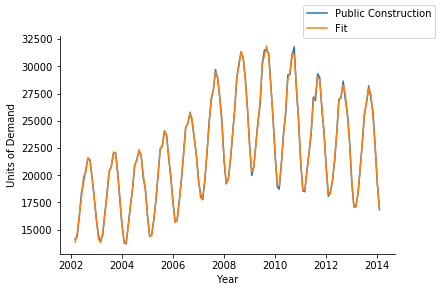

In [158]:
df_const['R2Public'] = df_const['R1Public'] - df_const['C']
df_const['R2PublicError'] = abs(df_const['R2Public']/df_const['Public Construction'])
df_const['fit'] = df_const['MovAvg'] + df_const['C']
df_const.drop(['sqErr'], axis = 1, inplace=True)
print('Average Error: ', sum(df_const['R2PublicError'])/len(df_const))
print(df_const)
fig,ax = plt.subplots()
ax.plot(df_const['Public Construction'], label='Public Construction')
ax.plot(df_const['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

### Here is a plot of the residual $R2Public$ for visualization purposes to observe any remaining patterns that we might want to capture, and also an autocorrelation analysis of the residual.

Correlation, lag  1     -0.5364207942486163
Correlation, lag  2     -0.0527529102850844
Correlation, lag  3     0.27943062008513875
Correlation, lag  4     -0.2550820705704478
Correlation, lag  5     0.0563539095598426
Correlation, lag  6     0.12481651289791953
Correlation, lag  7     -0.21963245697631947
Correlation, lag  8     -0.05556206170602232
Correlation, lag  9     0.3185854096227451
Correlation, lag  10     -0.3567562255690614
Correlation, lag  11     0.09835032946793902
Correlation, lag  12     0.3583038998286567
Correlation, lag  13     -0.5218042210563274
Correlation, lag  14     0.44315435558398475
Correlation, lag  15     -0.12454448399669753
Correlation, lag  16     -0.15260091451195026
Correlation, lag  17     0.21540972345128492
Correlation, lag  18     -0.06826298075357477
Correlation, lag  19     -0.2120045343717056
Correlation, lag  20     0.2257361324417972
Correlation, lag  21     -0.040168601260011864
Correlation, lag  22     -0.30486454387045925
Correlation, la

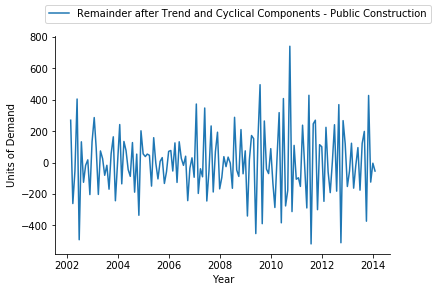

In [159]:
fig,ax = plt.subplots()
ax.plot(df_const['R2Public'],label='Remainder after Trend and Cyclical Components - Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,29):
    corr = df_const['R2Public'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

### A final graph to show the model versus the original data and, as well, the remander $R2Public$ to judge it relative to the original demand we were trying to fit.

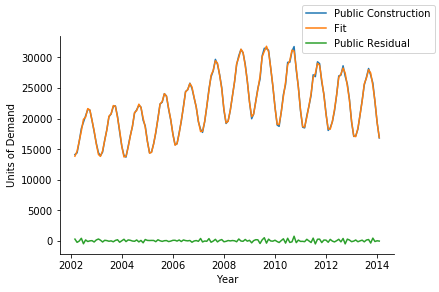

In [160]:
fig,ax = plt.subplots()
ax.plot(df_const['Public Construction'],label='Public Construction')
ax.plot(df_const['fit'],label='Fit')
ax.plot(df_const['R2Public'],label='Public Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()